In [3]:
import os
import random
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import math
import argparse
import json
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from selectivesearch import selective_search
import skimage
from skimage import io, color, img_as_ubyte
from skimage.transform import resize
import numpy as np
import torch.nn as nn
import torchvision
from torchvision.models import VGG19_BN_Weights
from torch import optim
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw, ImageFont

初始化数据集

In [7]:
'''
    VOC数据集的处理
    1、读取数据
    2、数据的预处理
    3、数据的加载
'''

class VOCdataset(Dataset):
    # 注意修改coco数据集的存放路径
    # "C:\Users\hjy\Downloads\VOCdevkit\VOCdevkit"
    def __init__(self, root=r'C:\Users\hjy\Downloads\VOCdevkit\VOCdevkit\VOC2012', mode='train', transform=None):
        # 确保模式是训练集或验证集
        assert mode in ['train', 'val'], "mode must be 'train' or 'val'"
        self.root = root# 数据集的根路径
        self.mode = mode# 当前模式（'train' 或 'val'）
        # 图像预处理（转换为张量并归一化）
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # 从ImageSets/Main目录读取指定模式的图像ID列表
        with open(os.path.join(root, 'ImageSets', 'Main', f'{mode}.txt'), 'r') as f:
            self.img_ids = [line.strip() for line in f]
        # 定义类别名称列表，包括背景类
        self.classes = ['background'] + [
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
            'bus', 'car', 'cat', 'chair', 'cow',
            'diningtable', 'dog', 'horse', 'motorbike', 'person',
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        ]
        # 创建类别到索引的映射
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        # 返回数据集的大小
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 获取指定索引的图像ID
        img_id = self.img_ids[idx]
        # 构造图像路径和标注路径
        img_path = os.path.join(self.root, 'JPEGImages', f'{img_id}.jpg')
        ann_path = os.path.join(self.root, 'Annotations', f'{img_id}.xml')

        img = Image.open(img_path).convert('RGB')# 将图片转换为RGB格式
        img = img.resize((224, 224))  # 调整图片尺寸为 224x224

        # 解析XML标注文件
        tree = ET.parse(ann_path)
        root = tree.getroot()
        rects = []# 用于存储边界框
        rela_locs = []# 用于存储相对位置（初始化为0）
        cats = [] # 用于存储类别索引
        width, height = int(root.find('size/width').text), int(root.find('size/height').text)# 获取图片原始宽高

        for obj in root.findall('object'):# 遍历每个对象
            bbox = obj.find('bndbox')# 获取边界框信息
            category = obj.find('name').text# 获取类别名称
            # 归一化边界框坐标
            xmin = float(bbox.find('xmin').text) / width
            ymin = float(bbox.find('ymin').text) / height
            xmax = float(bbox.find('xmax').text) / width
            ymax = float(bbox.find('ymax').text) / height
            rects.append([xmin, ymin, xmax, ymax])# 添加边界框
            rela_locs.append([0, 0, 0, 0])# 初始化相对位置
            # 将类别名称转换为索引
            if category in self.class_to_idx:
                cats.append(self.class_to_idx[category])
            else:
                print(f"Warning: Unknown category {category} in {ann_path}")# 警告未知类别

        # 对图像进行预处理
        if self.transform:
            img = self.transform(img)

        roi_idx_len = len(rects)# 获取候选区域数量
        return img, rects, roi_idx_len, rela_locs, cats# 返回图像和标注信息


if __name__ == '__main__':
    # 创建VOC数据集实例
    dataset = VOCdataset()
    # 打印数据集大小
    print(dataset.__len__())
    # 测试获取某一数据
    img, rects, roi_idx_len, rela_locs, cats = dataset.__getitem__(10)
    print(img, rects, roi_idx_len, rela_locs, cats)

    # 使用DataLoader加载数据集
    from torch.utils.data import DataLoader
    loader = DataLoader(dataset, batch_size=1)
    #for i, temp in enumerate(loader):
        #print(i, type(temp))

NameError: name 'Dataset' is not defined

构造训练集和验证集

In [ ]:
# 计算两个矩形框的IoU
def cal_iou(a, b):
    a_min_x, a_min_y, a_delta_x, a_delta_y = a
    b_min_x, b_min_y, b_delta_x, b_delta_y = b
    a_max_x = a_min_x + a_delta_x
    a_max_y = a_min_y + a_delta_y
    b_max_x = b_min_x + b_delta_x
    b_max_y = b_min_y + b_delta_y

    # 如果两个矩形框没有交集，则IoU为0
    if min(a_max_y, b_max_y) < max(a_min_y, b_min_y) or min(a_max_x, b_max_x) < max(a_min_x, b_min_x):
        return 0
    else:
        # 计算交集面积
        intersect_area = (min(a_max_y, b_max_y) - max(a_min_y, b_min_y) + 1) * \
                         (min(a_max_x, b_max_x) - max(a_min_x, b_min_x) + 1)
        # 计算并集面积
        union_area = (a_delta_x + 1) * (a_delta_y + 1) + \
                     (b_delta_x + 1) * (b_delta_y + 1) - intersect_area
        return intersect_area / union_area


# 解析VOC格式的XML标注文件
def parse_voc_annotations(ann_path, cat_dict):
    tree = ET.parse(ann_path)  # 解析XML文件
    root = tree.getroot()  # 获取根节点
    anns = []  # 初始化标注列表
    for obj in root.findall('object'):  # 遍历每个目标对象
        category = obj.find('name').text  # 获取目标类别名称
        bbox = obj.find('bndbox')  # 获取边界框信息
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # 保存标注信息，包括边界框和类别
        anns.append({'bbox': [xmin, ymin, xmax - xmin, ymax - ymin], 'category': cat_dict.get(category, 0)})
    return anns


# 对单张图片进行选择性搜索并生成候选区域
def ss_img(img_id, args, cat_dict):
    img_path = os.path.join(args.data_dir, 'JPEGImages', f"{img_id}.jpg")  # 获取图像路径
    ann_path = os.path.join(args.data_dir, 'Annotations', f"{img_id}.xml")  # 获取标注路径
    anns = parse_voc_annotations(ann_path, cat_dict)  # 解析标注文件，获得框和类别

    img = io.imread(img_path)  # 读取图像
    if img.ndim == 2:  # 如果是灰度图，则转为RGB格式
        img = color.gray2rgb(img)
    img = resize(img, (300, 300), anti_aliasing=True)  # 将图像调整为300x300大小
    img = img_as_ubyte(img)  # 转换为无符号8位整数格式
    _, ss_regions = selective_search(img, args.scale, args.sigma, args.min_size)  # 执行选择性搜索

    pos_regions = []  # 初始化正样本区域
    neg_regions = []  # 初始化负样本区域
    h, w = img.shape[:2]  # 获取图像高度和宽度

    # 遍历选择性搜索生成的候选区域
    for region in ss_regions:
        for ann in anns:
            iou = cal_iou(region['rect'], ann['bbox'])  # 计算候选区域与标注框的IoU
            rect = list(region['rect'])
            # 对候选框进行归一化处理，格式[x1, y1, x2, y2]
            rect[0] = rect[0] / w
            rect[1] = rect[1] / h
            rect[2] = rect[0] + rect[2] / w
            rect[3] = rect[1] + rect[3] / h
            gt_rect = list(ann['bbox'])
            gt_rect[0] = gt_rect[0] / w
            gt_rect[1] = gt_rect[1] / h
            gt_rect[2] = gt_rect[0] + gt_rect[2] / w
            gt_rect[3] = gt_rect[1] + gt_rect[3] / h
            # 根据IoU值判断是正样本还是负样本
            if iou >= 0.5:
                pos_regions.append({'rect': rect, 'gt_rect': gt_rect, 'category': ann['category']})
            elif iou >= 0.1:
                neg_regions.append({'rect': rect, 'gt_rect': gt_rect, 'category': 0})
    return pos_regions, neg_regions  # 返回正负样本区域


# 主函数
def main():
    # 设置命令行参数
    parser = argparse.ArgumentParser('parser to create regions for VOC2012')
    parser.add_argument('--data_dir', type=str, default='/home/mw/input/VOC4326/VOCdevkit/VOCdevkit/VOC2012')  # 数据集路径
    parser.add_argument('--mode', type=str, default='train')  # 数据模式（训练集或验证集）
    parser.add_argument('--save_dir', type=str, default='/home/mw/project')  # 保存路径
    parser.add_argument('--cats', type=str, nargs='*', default=[
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ])  # 类别名称
    parser.add_argument('--scale', type=float, default=30.0)  # 选择性搜索的尺度
    parser.add_argument('--sigma', type=float, default=0.8)  # 高斯平滑参数
    parser.add_argument('--min_size', type=int, default=50)  # 最小区域大小

    args, unknown = parser.parse_known_args()  # 解析命令行参数
    print(f"Unknown arguments ignored: {unknown}")

    os.makedirs(args.save_dir, exist_ok=True)  # 创建保存路径

    # 读取图像ID列表
    with open(os.path.join(args.data_dir, 'ImageSets', 'Main', f"{args.mode}.txt"), 'r') as f:
        img_ids = [line.strip() for line in f]

    # 创建类别到索引的映射
    cat_dict = {args.cats[i]: i + 1 for i in range(len(args.cats))}
    cat_dict['background'] = 0

    # 使用多线程加速处理
    with ThreadPoolExecutor(max_workers=4) as executor:
        ss_regions = list(tqdm(executor.map(lambda img_id: ss_img(img_id, args, cat_dict), img_ids), total=len(img_ids)))

    # 保存结果为JSON文件
    with open(os.path.join(args.save_dir, f"{args.mode}.json"), 'w', encoding='utf-8') as f:
        json.dump(ss_regions, f)


if __name__ == '__main__':
    main()

NameError: name 'argparse' is not defined

ROI Plooing模块

In [ ]:
class ROIPooling(nn.Module):
    def __init__(self, output_size): # 初始化函数，设置输出大小
        super().__init__()
        self.maxpool = nn.AdaptiveMaxPool2d(output_size)  # 创建一个自适应最大池化层，输出大小为output_size
        self.size = output_size  # 设置输出大小

    def forward(self, imgs, rois, roi_idx):
        """
        :param img: img:批次内的图像
        :param rois: rois:[[单张图片内框体],[],[]]，多个格式为归一化的[x1, y1, x2, y2]的框体
        :param roi_idx: [2]*6------->[2, 2, 2, 2, 2, 2]，每个roi属于哪张图
        # 将归一化的ROI坐标乘以特征图的高宽，得到实际像素位置。
        :return:
        """
        n = rois.shape[0] # 获取roi的数量
        h = imgs.shape[2] # 获取图像的高度
        w = imgs.shape[3] # 获取图像的宽度

        x1 = rois[:, 0] # 获取所有区域的左上角x坐标
        y1 = rois[:, 1] # 获取所有区域的左上角y坐标
        x2 = rois[:, 2] # 获取所有区域的右下角x坐标
        y2 = rois[:, 3] # 获取所有区域的右下角y坐标

        x1 = np.floor(x1 * w).astype(int) # 将x1坐标转换为图像的实际坐标
        x2 = np.ceil(x2 * w).astype(int) # 将x2坐标转换为图像的实际坐标
        y1 = np.floor(y1 * h).astype(int) # 将y1坐标转换为图像的实际坐标
        y2 = np.ceil(y2 * h).astype(int) # 将y2坐标转换为图像的实际坐标

        res = [] # 初始化结果列表
        for i in range(n): # 遍历每个区域
            img = imgs[roi_idx[i]].unsqueeze(dim=0) # 获取第i个区域所在的图像
            img = img[:, :, y1[i]:y2[i], x1[i]:x2[i]]  # 对图像进行裁剪，只保留区域内的部分
            img = self.maxpool(img) # 对裁剪后的图像进行最大池化操作
            res.append(img) # 将处理后的图像添加到结果列表中
        res = torch.cat(res, dim=0) # 将所有处理后的图像沿着批次维度拼接起来，最终res保存了所有池化后的ROI区域
        return res

if __name__ == '__main__':
    import numpy as np
    imgs = torch.randn(2, 10, 224, 224) # 创建一个随机的图像张量（batch_size, Channel, Height, Weight）
    rois = np.array([[0.2, 0.2, 0.4, 0.4],
                    [0.5, 0.5, 0.7, 0.7],
                    [0.1, 0.1, 0.3, 0.3]]) # 创建一个随机的区域张量（x1, y1, x2, y2）
    # roi_idx表示每个区域（Region of Interest，ROI）所在的图像的索引
    # 表示有三个区域，前两个区域在第一张图像上（索引为0），第三个区域在第二张图像上（索引为1）
    roi_idx = np.array([0, 0, 1])
    r = ROIPooling((7, 7)) # (7, 7)表示池化后的输出大小为7x7。这意味着无论输入区域的大小如何，ROIPooling层都会将其池化为7x7的大小
    print(r.forward(imgs, rois, roi_idx).shape)

NameError: name 'nn' is not defined

FastRCNN模型构建  
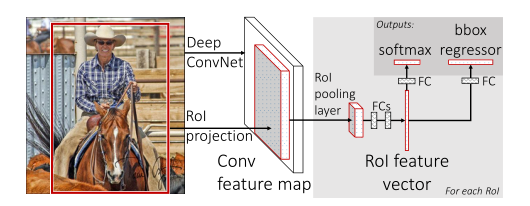  
- 输入一张图像，一组候选框，候选框是由选择性搜索生成的。
- 然后整张图像输入到主干网络得到特征图
- 将每个候选框(是在原图坐标上的)映射到特征图上，这里特征图是被缩小了的，候选框直接/缩小倍数
   现在框是在特征图上的
- 对于每个候选框，在特征图上截取对应区域特征。将区域划分为网格，对每个网格进行最大池化，从而得到固定大小的特征
- 分类和候选框回归:将候选框特征送入FC，一个分支输出分类结果，另外一个输出边框偏移

In [ ]:
class FastRCNN(nn.Module):
    def __init__(self, num_classes):
        """
        初始化FastRCNN模型
        :param num_classes: 类别数量（不包括背景类）
        """
        super().__init__()
        assert num_classes > 0, "num_classes must be greater than 0"  # 确保类别数量大于0
        self.num_classes = num_classes  # 类别数量

        # 加载预训练的VGG19模型
        vgg = torchvision.models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1)
        # 获取VGG19的特征提取部分，去掉最后一层池化层
        self.features = nn.Sequential(*list(vgg.features.children())[:-1])
        # ROIPooling层，用于将提取的特征调整为固定大小
        self.roipool = ROIPooling(output_size=(7, 7))
        # 获取VGG19分类部分的前几层，去掉最后一层全连接层
        self.output = nn.Sequential(*list(vgg.classifier.children())[:-1])
        """
        Linear(25088, 4096)
        ReLU
        Dropout
        Linear(4096, 4096)
        ReLU
        Dropout
        Linear(4096, 1000) # 最后一层是输出1000类（ImageNet）
        """
        # 分类层，输出每个类别（包括背景）的概率
        self.prob = nn.Linear(4096, num_classes + 1)  # 分类 + 背景类
        # 边界框回归层，输出每个类别的边界框调整参数
        self.loc = nn.Linear(4096, 4 * (num_classes + 1))  # 每类4个坐标参数

        # 损失函数定义
        self.cat_loss = nn.CrossEntropyLoss()  # 分类损失（交叉熵）
        self.loc_loss = nn.SmoothL1Loss()  # 边界框回归损失（Smooth L1 Loss）

    def forward(self, img, rois, roi_idx):
        """
        前向传播
        :param img: 输入的图像张量
        :param rois: 候选区域（Regions of Interest）
        :param roi_idx: 每个ROI所属的图像索引
        :return: 分类概率和边界框回归输出
        """
        res = self.features(img)  # 提取特征，输出是特征图 (batch_size, channels, height, width)
        res = self.roipool(res, rois, roi_idx)  # 将特征通过ROI池化层调整大小
        res = res.view(res.shape[0], -1)  # 展平特征张量
        features = self.output(res)  # 通过全连接层提取高层语义特征
        prob = self.prob(features)  # 分类概率
        loc = self.loc(features).view(-1, self.num_classes + 1, 4)  # 边界框回归参数
        return prob, loc

    def loss(self, prob, bbox, label, gt_bbox, lmb=1.0):
        """
        计算模型的总损失
        :param prob: 模型预测的分类概率
        :param bbox: 模型预测的边界框回归参数
        :param label: 实际类别标签
        :param gt_bbox: 实际边界框
        :param lmb: 损失平衡系数
        :return: 总损失、分类损失、边界框损失
        """
        # 检查标签是否超出类别范围
        if label.max() >= self.num_classes + 1:
            raise ValueError(f"Label index {label.max()} exceeds model's class count {self.num_classes + 1}")

        # 分类损失
        loss_cat = self.cat_loss(prob, label)
        # 处理标签和掩码
        lbl = label.view(-1, 1, 1).expand(label.size(0), 1, 4)  # 扩展维度
        mask = (label != 0).float().view(-1, 1, 1).expand(label.shape[0], 1, 4)  # 创建掩码，仅对非背景类计算回归损失
        # 边界框回归损失
        loss_loc = self.loc_loss(gt_bbox * mask, bbox.gather(1, lbl).squeeze(1) * mask)
        # 总损失 = 分类损失 + λ * 边界框损失
        loss = loss_cat + lmb * loss_loc
        return loss, loss_cat, loss_loc

训练与验证

In [ ]:
# 定义训练函数，输入参数为模型、训练数据集、优化器和命令行参数
# 训练时要用gpu，记得把参数--cuda的默认值改为True
def train(model, train_dataset, optimizer, args):
    model.train()
    num_batches = len(train_dataset) // args.batch_size
    indexes = np.random.permutation(len(train_dataset))

    loss_all, loss_cat_all, loss_loc_all, accuracy, num_samples = 0, 0, 0, 0, 0

    # 添加进度条
    with tqdm(total=num_batches, desc="Training", unit="batch") as pbar:
        for i in range(num_batches):
            imgs, rects, roi_idxs, rela_locs, cats = [], [], [], [], []
            for j in range(args.batch_size):
                idx = indexes[i * args.batch_size + j]
                img, rect, roi_idx_len, rela_loc, cat = train_dataset[idx]
                imgs.append(img.unsqueeze(0))
                rects += rect
                rela_locs += rela_loc
                roi_idxs += ([j] * roi_idx_len)
                cats += cat

            imgs = torch.cat(imgs, dim=0)
            rects = np.array(rects)
            rela_locs = torch.FloatTensor(rela_locs)
            cats = torch.LongTensor(cats)

            if args.cuda:
                imgs, rela_locs, cats = imgs.cuda(), rela_locs.cuda(), cats.cuda()

            optimizer.zero_grad()
            prob, bbox = model.forward(imgs, rects, roi_idxs)
            loss, loss_cat, loss_loc = model.loss(prob, bbox, cats, rela_locs)
            loss.backward()
            optimizer.step()

            num_samples += len(cats)
            loss_all += loss.item() * len(cats)
            loss_cat_all += loss_cat.item() * len(cats)
            loss_loc_all += loss_loc.item() * len(cats)
            accuracy += (torch.argmax(prob.detach(), dim=-1) == cats).sum().item()

            # 更新进度条
            pbar.update(1)

    return model, loss_all / num_samples, loss_cat_all / num_samples, loss_loc_all / num_samples, accuracy / num_samples
# 定义测试函数，输入参数为模型、验证数据集和命令行参数
def test(model, val_dataset, args):
    model.eval()
    num_batches = len(val_dataset) // args.batch_size
    indexes = np.random.permutation(len(val_dataset))

    loss_all, loss_cat_all, loss_loc_all, accuracy, num_samples = 0, 0, 0, 0, 0

    # 添加进度条
    with tqdm(total=num_batches, desc="Validation", unit="batch") as pbar:
        for i in range(num_batches):
            imgs, rects, roi_idxs, rela_locs, cats = [], [], [], [], []
            for j in range(args.batch_size):
                idx = indexes[i * args.batch_size + j]
                img, rect, roi_idx_len, rela_loc, cat = val_dataset[idx]
                imgs.append(img.unsqueeze(0))
                rects += rect
                rela_locs += rela_loc
                roi_idxs += ([j] * roi_idx_len)
                cats += cat

            imgs = torch.cat(imgs, dim=0)
            rects = np.array(rects)
            rela_locs = torch.FloatTensor(rela_locs)
            cats = torch.LongTensor(cats)

            if args.cuda:
                imgs, rela_locs, cats = imgs.cuda(), rela_locs.cuda(), cats.cuda()

            prob, bbox = model.forward(imgs, rects, roi_idxs)
            loss, loss_cat, loss_loc = model.loss(prob, bbox, cats, rela_locs)

            num_samples += len(cats)
            loss_all += loss.item() * len(cats)
            loss_cat_all += loss_cat.item() * len(cats)
            loss_loc_all += loss_loc.item() * len(cats)
            accuracy += (torch.argmax(prob, dim=-1) == cats).sum().item()

            # 更新进度条
            pbar.update(1)

    return model, loss_all / num_samples, loss_cat_all / num_samples, loss_loc_all / num_samples, accuracy / num_samples



def main():
    parser = argparse.ArgumentParser('parser for fast-rcnn') # 创建一个命令行参数解析器
    parser.add_argument('--batch_size', type=int, default=16) # 添加一个命令行参数--batch_size，用于指定批次大小，默认值为16
    parser.add_argument('--num_classes', type=int, default=20) # 添加一个命令行参数--num_classes，用于指定类别数量
    parser.add_argument('--learning_rate', type=float, default=2e-4) # 添加一个命令行参数--learning_rate，用于指定学习率，默认值为2e-4
    parser.add_argument('--epochs', type=int, default=1) # 添加一个命令行参数--epochs，用于指定训练的轮数，默认值为20
    parser.add_argument('--save_path', type=str,
                        default='/home/mw/project/fast_rcnn.pkl') # 添加一个命令行参数--save_path，用于指定模型保存的路径，默认值为'./model/fast_rcnn.pkl'
    parser.add_argument('--cuda', type=bool, default=False)

     # Use parse_known_args() to ignore unknown arguments
    args, unknown = parser.parse_known_args()
    print(f"Unknown arguments ignored: {unknown}")
    train_dataset = VOCdataset(mode='train') # 解析命令行参数，并将结果保存在args中
    print("-----------------",train_dataset.__len__())
    valid_dataset = VOCdataset(mode='val') # 创建一个实例，模式为'val'
    print("-----------------", valid_dataset.__len__())
    model = FastRCNN(num_classes=args.num_classes) # 创建一个FastRCNN模型实例，类别数量为args.num_classes
    if args.cuda:# 如果args.cuda为True，则将模型移动到GPU上
        model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # 创建一个Adam优化器，优化目标为模型的参数，学习率为args.learning_rate

    for epoch in range(args.epochs):# 对于每一个训练轮次
        print("Epoch %d:" % epoch)# 打印当前轮次
        model, train_loss, train_loss_cat, train_loss_loc, train_accuracy = train(
            model, train_dataset, optimizer, args) # 调用train函数进行训练，并获取模型、总损失、类别损失、位置损失和准确率
        print("Train: loss=%.4f, loss_cat=%.4f, loss_loc=%.4f, accuracy=%.4f" %
              (train_loss, train_loss_cat, train_loss_loc, train_accuracy))# 打印训练的损失和准确率
        model, valid_loss, valid_loss_cat, valid_loss_loc, valid_accuracy = test(
            model, valid_dataset, args)# 打印训练的损失和准确率
        print("Valid: loss=%.4f, loss_cat=%.4f, loss_loc=%.4f, accuracy=%.4f" %
              (valid_loss, valid_loss_cat, valid_loss_loc, valid_accuracy))# 打印验证的损失和准确率

    torch.save(model.state_dict(), args.save_path) # 将模型的状态字典保存到args.save_path指定的路径


if __name__ == '__main__':
    main() # 如果当前脚本被直接运行，则调用main函数

测试

In [ ]:
# 测试时如果用gpu，则：
# 1. 将模型加载到gpu上：trained_net = torch.load(args.model)，不加 map_location = 'cpu'
# 2. 把参数--cuda的默认值改为True

# 定义计算IoU（交并比）的函数，输入参数为两个矩形框
def cal_iou(a, b):
    a_min_x, a_min_y, a_max_x, a_max_y = a
    b_min_x, b_min_y, b_max_x, b_max_y = b
    if min(a_max_y, b_max_y) < max(a_min_y, b_min_y) or min(a_max_x, b_max_x) < max(a_min_x, b_min_x):
        return 0
    else:
        intersect_area = (min(a_max_y, b_max_y) - max(a_min_y, b_min_y) + 1) * \
            (min(a_max_x, b_max_x) - max(a_min_x, b_min_x) + 1)
        union_area = (a_max_x - a_min_x + 1) * (a_max_y - a_min_y + 1) + \
            (b_max_x - b_min_x + 1) * (b_max_y - b_min_y + 1) - intersect_area
    return intersect_area / union_area


def main():
    parser = argparse.ArgumentParser('parser for testing fast-rcnn')
    parser.add_argument('--jpg_path', type=str,
                        default='/home/mw/input/VOC4326/VOCdevkit/VOCdevkit/VOC2012/JPEGImages/2012_001720.jpg')# 添加一个命令行参数--jpg_path，用于指定待测试的图像的路径
    parser.add_argument('--save_path', type=str, default='/home/mw/project/sample.png')
    parser.add_argument('--save_type', type=str, default='png')
    parser.add_argument('--model', type=str, default='/home/mw/project/fast_rcnn.pkl') # 添加一个命令行参数--model，用于指定模型的路径
    parser.add_argument('--num_classes', type=int, default=20)
    parser.add_argument('--scale', type=float, default=30.0) # 添加一个命令行参数--scale，用于指定选择性搜索的尺度，默认值为30.0
    parser.add_argument('--sigma', type=float, default=0.8) # 添加一个命令行参数--sigma，用于指定选择性搜索的高斯平滑参数，默认值为0.8
    parser.add_argument('--min_size', type=int, default=50) # 添加一个命令行参数--min_size，用于指定选择性搜索的最小区域大小，默认值为50
    parser.add_argument('--cats', type=str, nargs='*', default=[
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]) # 添加一个命令行参数--cats，用于指定需要处理的类别
    parser.add_argument('--cuda', type=bool, default=False)
    # Use parse_known_args() to ignore unknown arguments
    args, unknown = parser.parse_known_args()
    
    print(f"Unknown arguments ignored: {unknown}")

    # trained_net = torch.load(args.model) # 加载模型
    trained_net = torch.load(args.model, map_location = 'cpu') # 加载模型

    model = FastRCNN(num_classes=args.num_classes) # 创建一个FastRCNN模型实例，类别数量为args.num_classes
    model.load_state_dict(trained_net) # 将加载的模型的状态字典加载到FastRCNN模型实例中
    if args.cuda: # 如果args.cuda为True，则将模型移动到GPU上
        model.cuda()

    img = skimage.io.imread(args.jpg_path) # 读取图像
    h = img.shape[0] # 获取图像的高度
    w = img.shape[1] # 获取图像的宽度
    _, ss_regions = selective_search(
        img, args.scale, args.sigma, args.min_size) # 对图像进行选择性搜索，获取候选区域
    rois = []
    for region in ss_regions: # 遍历每个候选区域
        rect = list(region['rect']) # 获取候选区域的矩形框
        rect[0] = rect[0] / w # 将矩形框的x坐标转换为相对于图像宽度的比例
        rect[1] = rect[1] / h # 将矩形框的y坐标转换为相对于图像高度的比例
        rect[2] = rect[0] + rect[2] / w # 将矩形框的宽度转换为相对于图像宽度的比例
        rect[3] = rect[1] + rect[3] / h # 将矩形框的高度转换为相对于图像高度的比例
        rois.append(rect) # 将处理后的矩形框添加到列表中
    img = Image.fromarray(img) # 将图像数组转换为PIL图像
    img_tensor = img.resize([224, 224]) # 将图像大小调整为224x224
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([
                                   0.485, 0.456, -.406], [0.229, 0.224, 0.225])]) # 创建一个图像预处理管道，包括将PIL图像转换为张量和标准化
    img_tensor = transform(img_tensor).unsqueeze(0) # 对图像进行预处理，并添加一个新的维度
    if args.cuda: # 如果args.cuda为True，则将图像张量移动到GPU
        img_tensor = img_tensor.cuda()
    rois = np.array(rois) # 将候选区域的列表转换为数组
    roi_idx = [0] * rois.shape[0] # 创建一个列表，长度为候选区域的数量，所有元素都为0

    prob, rela_loc = model.forward(img_tensor, rois, roi_idx) # 前向传播，计算预测的概率和边界框
    prob = torch.nn.Softmax(dim=-1)(prob).cpu().detach().numpy() # 对预测的概率进行softmax操作，并将结果转换为numpy数组
    # rela_loc = rela_loc.cpu().detach().numpy()[:, 1:, :].mean(axis=1)
    labels = []
    max_probs = []
    bboxs = []
    for i in range(len(prob)): # 遍历每个预测的概率
        if prob[i].max() > 0.8 and np.argmax(prob[i], axis=0) != 0: # 如果最大概率大于0.8且对应的类别不是背景，则认为候选区域是有效的
            # proposal regions is directly used because of limited training epochs, bboxs predicted are not precise
            # bbox = [(rois[i][2] - rois[i][0]) * rela_loc[i][0] + 0.5 * (rois[i][2] + rois[i][0]),
            #         (rois[i][3] - rois[i][1]) * rela_loc[i][1] + 0.5 * (rois[i][3] + rois[i][1]),
            #         np.exp(rela_loc[i][2]) * rois[i][2],
            #         np.exp(rela_loc[i][3]) * rois[i][3]]
            # bbox = [bbox[0] - 0.5 * bbox[2],
            #         bbox[1] - 0.5 * bbox[3],
            #         bbox[0] + 0.5 * bbox[2],
            #         bbox[1] + 0.5 * bbox[3]]
            labels.append(np.argmax(prob[i], axis=0))  # 将有效候选区域的类别添加到列表中
            max_probs.append(prob[i].max()) # 将有效候选区域的最大概率添加到列表中
            rois[i] = [int(w * rois[i][0]), int(h * rois[i][1]),
                       int(w * rois[i][2]), int(w * rois[i][3])] # 将候选区域的矩形框的坐标和大小转换为相对于原图的像素值
            bboxs.append(rois[i]) # 将处理后的矩形框添加到列表中
    labels = np.array(labels) # 将类别的列表转换为数组
    max_probs = np.array(max_probs) # 将最大概率的列表转换为数组
    bboxs = np.array(bboxs) # 将矩形框的列表转换为数组
    order = np.argsort(-max_probs) # 对最大概率进行降序排序，获取排序后的索引
    labels = labels[order] # 根据排序的索引重新排序类别
    max_probs = max_probs[order]
    bboxs = bboxs[order]

    # 下面的代码是进行非极大值抑制（NMS），用于去除重叠的候选区域
    nms_labels = []
    nms_probs = []
    nms_bboxs = []
    del_indexes = []
    for i in range(len(labels)):
        if i not in del_indexes:
            for j in range(len(labels)):
                if j not in del_indexes and cal_iou(bboxs[i], bboxs[j]) > 0.3:
                    del_indexes.append(j)
            nms_labels.append(labels[i])
            nms_probs.append(max_probs[i])
            nms_bboxs.append(bboxs[i])

    # 将预测结果绘制到图像上
    cat_dict = {(i + 1): args.cats[i] for i in range(len(args.cats))}
    cat_dict[0] = 'background'
    #font = ImageFont.truetype('./fonts/chinese_cht.ttf', size=16)
    draw = ImageDraw.Draw(img)
    for i in range(len(nms_labels)):
        draw.polygon([(nms_bboxs[i][0], nms_bboxs[i][1]), (nms_bboxs[i][2], nms_bboxs[i][1]),
                      (nms_bboxs[i][2], nms_bboxs[i][3]), (nms_bboxs[i][0], nms_bboxs[i][3])], outline=(255, 0, 0))
        draw.text((nms_bboxs[i][0] + 5, nms_bboxs[i][1] + 5), '%s %.2f%%' % (
            cat_dict[nms_labels[i]], 100 * max_probs[i]), fill=(255, 0, 0))
    img.save(args.save_path, args.save_type) # 将绘制了预测结果的图像保存到指定的路径


if __name__ == '__main__':
    main()